In [8]:
#FoS
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# === Save Directory for Plots
output_dir = r"output"
os.makedirs(output_dir, exist_ok=True)

# === Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# === Load and preprocess dataset
df = pd.read_csv(r"resources/data.csv")
X = df.drop(columns=["FoS", "SeismicFoS"]).values
y = df["FoS"].values  # ✅ Switched back to FoS

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# === Define the ANN Model
class ANN(nn.Module):
    def __init__(self, input_dim, h1, h2, h3):
        super(ANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, h1), nn.ReLU(),
            nn.Linear(h1, h2), nn.ReLU(),
            nn.Linear(h2, h3), nn.ReLU(),
            nn.Linear(h3, 1)
        )
    def forward(self, x):
        return self.model(x)

# === Evaluation Function
def evaluate_model(h1, h2, h3, lr):
    model = ANN(X_train.shape[1], h1, h2, h3)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training
    for epoch in range(100):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train_tensor).numpy()
        y_test_pred = model(X_test_tensor).numpy()

    return {
        "r2_train": r2_score(y_train, y_train_pred),
        "r2_test": r2_score(y_test, y_test_pred),
        "rmse_train": root_mean_squared_error(y_train, y_train_pred),
        "mse_train": mean_squared_error(y_train, y_train_pred),
        "mae_train": mean_absolute_error(y_train, y_train_pred),
        "mse_test": mean_squared_error(y_test, y_test_pred),
        "mae_test": mean_absolute_error(y_test, y_test_pred),
        "rmse_test": root_mean_squared_error(y_test, y_test_pred),
        "y_train_pred": y_train_pred,
        "y_test_pred": y_test_pred
    }

# === Run Evaluation
params = (64, 32, 16, 0.001)  # (h1, h2, h3, learning_rate)
results = evaluate_model(*params)

# === Print Results
print(f"\n📊 ANN Evaluation for FoS with Architecture {params[:3]} and LR = {params[3]}")
print(f"R² (Train): {results['r2_train']:.6f}")
print(f"R² (Test):  {results['r2_test']:.6f}")
print(f"RMSE (Train): {results['rmse_train']:.6f}")
print(f"RMSE (Test):  {results['rmse_test']:.6f}")
print(f"MAE (Train): {results['mae_train']:.6f}")
print(f"MAE (Test):  {results['mae_test']:.6f}")
print(f"MSE (Train): {results['mse_train']:.6f}")
print(f"MSE (Test):  {results['mse_test']:.6f}")

# === Plot 1: Actual vs Predicted (Train & Test)
fig1 = make_subplots(rows=1, cols=2, subplot_titles=["Train Set", "Test Set"])
fig1.add_trace(go.Scatter(y=y_train, mode='lines', name='Actual (Train)'), row=1, col=1)
fig1.add_trace(go.Scatter(y=results["y_train_pred"].flatten(), mode='lines', name='Predicted (Train)'), row=1, col=1)
fig1.add_trace(go.Scatter(y=y_test, mode='lines', name='Actual (Test)'), row=1, col=2)
fig1.add_trace(go.Scatter(y=results["y_test_pred"].flatten(), mode='lines', name='Predicted (Test)'), row=1, col=2)
fig1.update_layout(title_text="Actual vs Predicted - FoS ANN Model", height=500, width=1000)
fig1.write_html(os.path.join(output_dir, "fos_actual_vs_predicted.html"))
fig1.show()

# === Plot 2: Bar Chart Comparison of Metrics
fig2 = go.Figure()
fig2.add_trace(go.Bar(name='Train', x=['R²', 'RMSE', 'MAE'],
                      y=[results["r2_train"], results["rmse_train"], results["mae_train"]]))
fig2.add_trace(go.Bar(name='Test', x=['R²', 'RMSE', 'MAE'],
                      y=[results["r2_test"], results["rmse_test"], results["mae_test"]]))
fig2.update_layout(barmode='group', title="Performance Metrics (Train vs Test) - FoS", height=400, width=800)
fig2.write_html(os.path.join(output_dir, "fos_metrics_comparison.html"))
fig2.show()



📊 ANN Evaluation for FoS with Architecture (64, 32, 16) and LR = 0.001
R² (Train): 0.968497
R² (Test):  0.918675
RMSE (Train): 0.204658
RMSE (Test):  0.362793
MAE (Train): 0.130767
MAE (Test):  0.225474
MSE (Train): 0.041885
MSE (Test):  0.131619


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed


📊 ANN Evaluation for SeismicFoS with Architecture (64, 32, 16) and LR = 0.001
R² (Train): 0.944597
R² (Test):  0.773463
RMSE (Train): 0.205567
RMSE (Test):  0.446890
MAE (Train): 0.131247
MAE (Test):  0.271266


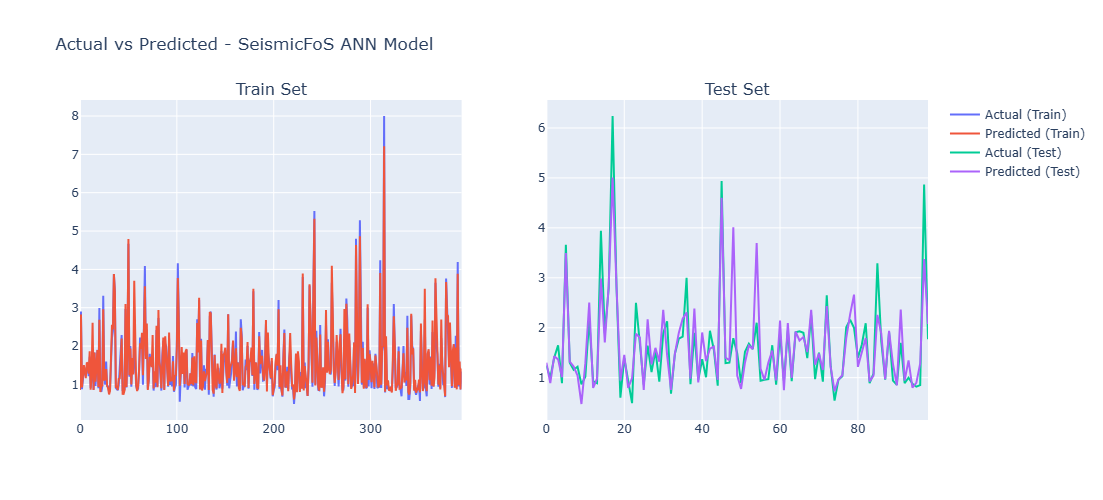

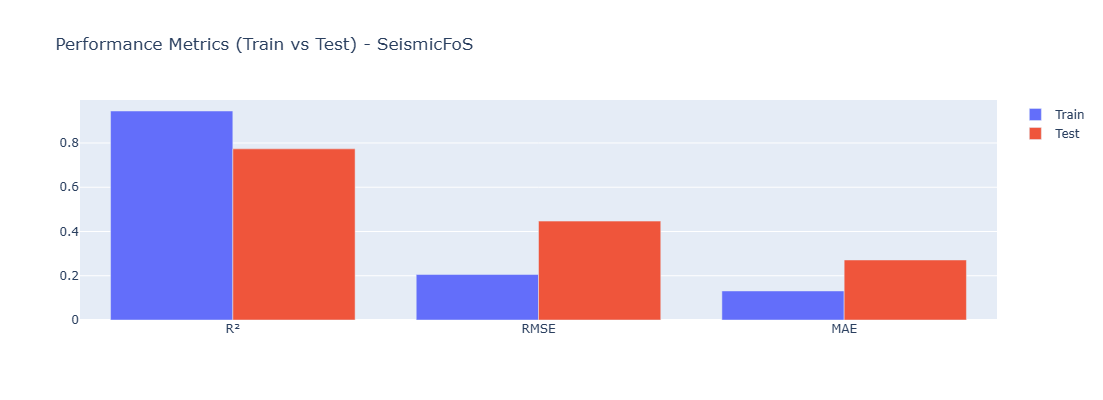

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# === Save Directory for Plots
output_dir = r"C:\Users\vishn\OneDrive\Documents\Machine Learning\ANN_simple\base_ANN"
os.makedirs(output_dir, exist_ok=True)

# === Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# === Load and preprocess dataset
df = pd.read_csv(r"C:\Users\vishn\OneDrive\Documents\Machine Learning\Vishnu_phd.csv")
X = df.drop(columns=["FoS", "SeismicFoS"]).values
y = df["SeismicFoS"].values  # ✅ Changed to SeismicFoS

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# === Define the ANN Model
class ANN(nn.Module):
    def __init__(self, input_dim, h1, h2, h3):
        super(ANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, h1), nn.ReLU(),
            nn.Linear(h1, h2), nn.ReLU(),
            nn.Linear(h2, h3), nn.ReLU(),
            nn.Linear(h3, 1)
        )
    def forward(self, x):
        return self.model(x)

# === Evaluation Function
def evaluate_model(h1, h2, h3, lr):
    model = ANN(X_train.shape[1], h1, h2, h3)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training
    for epoch in range(100):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train_tensor).numpy()
        y_test_pred = model(X_test_tensor).numpy()

    return {
        "r2_train": r2_score(y_train, y_train_pred),
        "r2_test": r2_score(y_test, y_test_pred),
        "rmse_train": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "mae_train": mean_absolute_error(y_train, y_train_pred),
        "rmse_test": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "mae_test": mean_absolute_error(y_test, y_test_pred),
        "y_train_pred": y_train_pred,
        "y_test_pred": y_test_pred
    }

# === Run Evaluation
params = (64, 32, 16, 0.001)  # (h1, h2, h3, learning_rate)
results = evaluate_model(*params)

# === Print Results
print(f"\n📊 ANN Evaluation for SeismicFoS with Architecture {params[:3]} and LR = {params[3]}")
print(f"R² (Train): {results['r2_train']:.6f}")
print(f"R² (Test):  {results['r2_test']:.6f}")
print(f"RMSE (Train): {results['rmse_train']:.6f}")
print(f"RMSE (Test):  {results['rmse_test']:.6f}")
print(f"MAE (Train): {results['mae_train']:.6f}")
print(f"MAE (Test):  {results['mae_test']:.6f}")

# === Plot 1: Actual vs Predicted (Train & Test)
fig1 = make_subplots(rows=1, cols=2, subplot_titles=["Train Set", "Test Set"])
fig1.add_trace(go.Scatter(y=y_train, mode='lines', name='Actual (Train)'), row=1, col=1)
fig1.add_trace(go.Scatter(y=results["y_train_pred"].flatten(), mode='lines', name='Predicted (Train)'), row=1, col=1)
fig1.add_trace(go.Scatter(y=y_test, mode='lines', name='Actual (Test)'), row=1, col=2)
fig1.add_trace(go.Scatter(y=results["y_test_pred"].flatten(), mode='lines', name='Predicted (Test)'), row=1, col=2)
fig1.update_layout(title_text="Actual vs Predicted - SeismicFoS ANN Model", height=500, width=1000)
fig1.write_html(os.path.join(output_dir, "seismicfos_actual_vs_predicted.html"))
fig1.show()

# === Plot 2: Bar Chart Comparison of Metrics
fig2 = go.Figure()
fig2.add_trace(go.Bar(name='Train', x=['R²', 'RMSE', 'MAE'],
                      y=[results["r2_train"], results["rmse_train"], results["mae_train"]]))
fig2.add_trace(go.Bar(name='Test', x=['R²', 'RMSE', 'MAE'],
                      y=[results["r2_test"], results["rmse_test"], results["mae_test"]]))
fig2.update_layout(barmode='group', title="Performance Metrics (Train vs Test) - SeismicFoS", height=400, width=800)
fig2.write_html(os.path.join(output_dir, "seismicfos_metrics_comparison.html"))
fig2.show()
